<a href="https://colab.research.google.com/github/Sopralapanca/CommonLitChallenge/blob/main/TrainLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/Sopralapanca/CommonLitChallenge.git"

Cloning into 'CommonLitChallenge'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 190 (delta 99), reused 107 (delta 47), pack-reused 0
Receiving objects: 100% (190/190), 10.76 MiB | 13.79 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [3]:
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
train_path = "/content/CommonLitChallenge/data/dataset.zip"

train_data = pd.read_csv(train_path, compression='zip', sep=',', index_col=0)

# Data prepatation for the LLM

In [5]:
def oversample_df(df):
    """
    :param df: Dataframe to be overampled based on prompt_id
    :return: Dataframe oversampled
    """
    classes = df["prompt_id"].value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df["prompt_id"] == key])
    classes_sample = []
    for i in range(1, len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe, classes_list[0]], axis=0)

    return final_df

In [6]:
import copy
import numpy as np
import more_itertools

import torch
from torch.utils.data import Sampler, Dataset, DataLoader

class SmartBatchingDataset(Dataset):
    def __init__(self, df, tokenizer, input_cols, target_cols, features_cols):
        super(SmartBatchingDataset, self).__init__()

        input_df = copy.deepcopy(df[input_cols])
        features_df = copy.deepcopy(df[features_cols])

        # Combine strings from multiple columns with [CLS], [SEP], and [SEP] separators
        input_df['combined_col'] = input_df.apply(
            lambda row: tokenizer.cls_token + ' ' + f' {tokenizer.sep_token} '.join(row) + f' {tokenizer.sep_token}',
            axis=1)

        self._data = [
            input_df['combined_col'].apply(tokenizer.tokenize).apply(tokenizer.convert_tokens_to_ids).to_list(),
            features_df.values.tolist()]
        self._targets = df[target_cols].values.tolist() if target_cols is not None else None
        self.sampler = None

    def __len__(self):
        return len(self._data)

    def __getitem__(self, item):
        if self._targets is not None:
            return [self._data[0][item], self._data[1][item]], self._targets[item]
        else:
            return [self._data[0][item], self._data[1][item]]

    def get_dataloader(self, batch_size, max_len, pad_id):

        self.sampler = SmartBatchingSampler(
            data_source=self._data[0],
            batch_size=batch_size
        )
        collate_fn = SmartBatchingCollate(
            targets=self._targets,
            max_length=max_len,
            pad_token_id=pad_id
        )
        dataloader = DataLoader(
            dataset=self,
            batch_size=batch_size,
            sampler=self.sampler,
            collate_fn=collate_fn,
            pin_memory=True,
            num_workers=1 # calcolare grafico con i tempi impiegati per capire qual è il numero di worker migliore da utilizzare
        )
        return dataloader


class SmartBatchingSampler(Sampler):
    def __init__(self, data_source, batch_size):
        super(SmartBatchingSampler, self).__init__(data_source)
        self.len = len(data_source)
        sample_lengths = [len(seq) for seq in data_source]
        argsort_inds = np.argsort(sample_lengths)
        self.batches = list(more_itertools.chunked(argsort_inds, n=batch_size))
        self._backsort_inds = None

    def __iter__(self):
        if self.batches:
            last_batch = self.batches.pop(-1)
            np.random.shuffle(self.batches)
            self.batches.append(last_batch)
        self._inds = list(more_itertools.flatten(self.batches))
        yield from self._inds

    def __len__(self):
        return self.len

    @property
    def backsort_inds(self):
        if self._backsort_inds is None:
            self._backsort_inds = np.argsort(self._inds)
        return self._backsort_inds


class SmartBatchingCollate:
    def __init__(self, targets, max_length, pad_token_id):
        self._targets = targets
        self._max_length = max_length
        self._pad_token_id = pad_token_id

    def __call__(self, batch):
        if self._targets is not None:
            sequences, targets = list(zip(*batch))
        else:
            sequences = list(batch)

        ids = []
        features = []
        for i in range(len(sequences)):
            ids.append(sequences[i][0])
            features.append(sequences[i][1])

        input_ids, attention_mask = self.pad_sequence(
            ids,
            max_sequence_length=self._max_length,
            pad_token_id=self._pad_token_id
        )

        if self._targets is not None:
            output = [input_ids, features], attention_mask, torch.tensor(targets)
        else:
            output = [input_ids, features], attention_mask
        return output

    def pad_sequence(self, sequence_batch, max_sequence_length, pad_token_id):
        max_batch_len = max(len(sequence) for sequence in sequence_batch)
        max_len = min(max_batch_len, max_sequence_length)
        padded_sequences, attention_masks = [[] for i in range(2)]
        attend, no_attend = 1, 0
        for sequence in sequence_batch:
            # As discussed above, truncate if exceeds max_len
            new_sequence = list(sequence[:max_len])

            attention_mask = [attend] * len(new_sequence)
            pad_length = max_len - len(new_sequence)

            new_sequence.extend([pad_token_id] * pad_length)
            attention_mask.extend([no_attend] * pad_length)

            padded_sequences.append(new_sequence)
            attention_masks.append(attention_mask)

        padded_sequences = torch.tensor(padded_sequences)
        attention_masks = torch.tensor(attention_masks)
        return padded_sequences, attention_masks


In [7]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer


def pipeline(config, training_data, input_cols, target_cols, features, split=0.2, oversample=False):
    """
    :param config:          model configuration dictionary
    :param training_data:   dataframe object with representing the dataset
    :param input_cols:      list of strings defining the columns of the dataframe that needs to be input of the LLM
    :param target_cols:     list of strings defining the columns of the dataframe for the target
    :param features:        list of strings defining the columns of the dataframe that rapresent the added feature to be concatenated as input to the feedforward net
    :param split:           float, percentage of the size of the validation set and test set
    :param oversample:      boolean, if true the training set will be oversampled
    :return:                training, validation, test loaders and the tokenizer used
    """

    train, test = train_test_split(training_data, test_size=split, random_state=42, stratify=training_data["prompt_id"])
    train, valid = train_test_split(train, test_size=split, random_state=42, stratify=train["prompt_id"])

    if oversample:
        train = oversample_df(train)

    tokenizer = AutoTokenizer.from_pretrained(config['model'])

    train_set = SmartBatchingDataset(train, tokenizer, input_cols, target_cols, features_cols=features)
    valid_set = SmartBatchingDataset(valid, tokenizer, input_cols, target_cols, features_cols=features)
    test_set = SmartBatchingDataset(test, tokenizer, input_cols, target_cols, features_cols=features)

    train_loader = train_set.get_dataloader(batch_size=config['batch_size'], max_len=config["max_length"],
                                            pad_id=tokenizer.pad_token_id)
    valid_loader = valid_set.get_dataloader(batch_size=config['batch_size'], max_len=config["max_length"],
                                            pad_id=tokenizer.pad_token_id)
    test_loader = test_set.get_dataloader(batch_size=config['batch_size'], max_len=config["max_length"],
                                          pad_id=tokenizer.pad_token_id)

    return train_loader, valid_loader, test_loader, tokenizer

# Model Definition

In [8]:
import torch.nn as nn
from transformers import AutoModel, AutoConfig

class RegressorModel(nn.Module):
    def __init__(self, name, fflayers, ffdropout,
                 features_dim, target_cols, activation_function,
                 freeze_encoder=True,pooling="mean-pooling", dropoutLLM=False):
        super(RegressorModel, self).__init__()

        """
        :param name:                strings, model name to be downloaded with huggingsface transformers
        :param fflayers:            int, number of layers of the feedforward network
        :param ffdropout:           float, percentage of dropout between LLM embeddings and feedforward net
        :param features_dim:        int, dimension of the feature extracted
        :param target_cols:         list of strings, columns of the dataframe that represents the target
        :param activation_function: string, activation function to use
        :param freeze_encoder:      boolean, if True the LLM is freezed and will be not trained
        :param pooling:             strings, pooling method to user
        :param dropoutLLM:          boolean, if False dropout percentage of LLM will be setted to 0
        """


        self.model_name = name
        self.pooling = pooling
        self.model_config = AutoConfig.from_pretrained(self.model_name)
        self.target_cols = target_cols
        self.drop = nn.Dropout(p=ffdropout)
        self.fflayers = fflayers


        if not dropoutLLM:
            self.model_config.hidden_dropout_prob = 0.0
            self.model_config.attention_probs_dropout_prob = 0.0

        self.encoder = AutoModel.from_pretrained(self.model_name, config=self.model_config)

        if freeze_encoder:
            for param in self.encoder.base_model.parameters():
                param.requires_grad = False

        size = self.encoder.config.hidden_size + features_dim
        # The output layer that takes the last hidden layer of the BERT model
        self.cls_layer1 = nn.Linear(size, 2*size)

        self.ff_hidden_layers = nn.ModuleList()
        size = 2*size
        for _ in range(self.fflayers):
            out_size = int(size/2)
            self.ff_hidden_layers.append(nn.Linear(size, out_size))
            size = out_size

        self.act = None
        if activation_function == 'relu':
            self.act = nn.ReLU()

        if activation_function == 'leaky-relu':
            self.act = nn.LeakyReLU()

        # last layer
        self.output_layer = nn.Linear(size, len(self.target_cols))

    def forward(self, inputs, attention_mask):

        input_ids = inputs[0]
        features = inputs[1]

        features = torch.tensor(features).float().to(input_ids.device)


        # Feed the input to Bert model to obtain contextualized representations
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask,
                               output_hidden_states=False)

        if self.pooling == 'cls':
            # Obtain the representations of [CLS] heads
            logits = outputs.last_hidden_state[:, 0, :]

        if self.pooling == 'mean-pooling':
            last_hidden_state = outputs.last_hidden_state
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            logits = sum_embeddings / sum_mask


        combined_features = torch.cat((logits, features), dim=1) # combine bert embeddings with features extracted from the dataset

        output = self.drop(combined_features)
        output = self.cls_layer1(output)

        for layer in self.ff_hidden_layers:
            output = self.act(layer(output))

        output = self.output_layer(output)
        return output

# Training Loop

In [9]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [34]:
import gc

class Trainer:
    def __init__(self, model, loaders, epochs, accelerator, lr):
        """
        :param model:       PyTorch model to train
        :param loaders:     tuple of DataLoaders, (train loader, valid loader)
        :param epochs:      int, max epochs to train a model
        :param accelerator: PyTorch device, device for gradient step accumulation
        :param lr:          float, learning rate
        """

        self.model = model
        self.train_loader, self.val_loader = loaders

        self.epochs = epochs

        self.accelerator = accelerator

        self.lr = lr

        self.optim = self._get_optim()

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optim, T_0=5, eta_min=1e-7)

        self.train_losses = {
            "loss": [],
            "content": [],
            "wording": []
        }
        self.val_losses = {
            "loss": [],
            "content": [],
            "wording": []
        }


    def prepare(self):
        self.model, self.optim, self.train_loader, self.val_loader, self.scheduler = self.accelerator.prepare(
            self.model,
            self.optim,
            self.train_loader,
            self.val_loader,
            self.scheduler
        )

    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': 0.01},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.lr, eps=1e-6)
        return optimizer

    def loss_fn(self, outputs, targets, multioutput=True):
        colwise_rmse = torch.sqrt(torch.mean((targets-outputs)**2, dim=0))
        if multioutput:
            content_loss = colwise_rmse[0]
            wording_loss = colwise_rmse[1]
        else:
            content_loss = 0.
            wording_loss = 0.

        loss = torch.mean(colwise_rmse, dim=0)

        return loss, content_loss, wording_loss

    def train_one_epoch(self, epoch, multioutput, outer_progress="", verbose=True):

        running_loss = 0.
        c_loss = 0.
        w_loss = 0.

        inner_iterations = len(self.train_loader)

        idx = 0
        for el in self.train_loader:
            input_ids, attention_mask, target = el

            with self.accelerator.accumulate(self.model):
                output = self.model(inputs=input_ids, attention_mask=attention_mask)

                loss, content_loss, wording_loss = self.loss_fn(output, target, multioutput)
                running_loss += loss.item()
                c_loss += content_loss
                w_loss += wording_loss

                self.accelerator.backward(loss)

                self.optim.step()

                self.scheduler.step(epoch - 1 + idx / len(self.train_loader))

                self.optim.zero_grad()

                del input_ids, attention_mask, target, loss

                if verbose:
                    inner_progress = f"Training Batch: [{idx}/{inner_iterations}]"
                    print(f"\r{outer_progress} {inner_progress}", end="")

            idx += 1

        train_loss = running_loss / len(self.train_loader)
        c_loss = c_loss / len(self.train_loader)
        w_loss = w_loss / len(self.train_loader)
        self.train_losses["loss"].append(train_loss)
        self.train_losses["content"].append(c_loss)
        self.train_losses["wording"].append(w_loss)

        if verbose:
            inner_progress = f"Training Batch:[{idx}/{inner_iterations}] training loss: {self.train_losses['loss'][-1]}"
            print(f"\r{outer_progress} {inner_progress}", end="")

    @torch.no_grad()
    def valid_one_epoch(self, epoch, multioutput, outer_progress="", verbose=True):

        running_loss = 0.
        c_loss = 0.
        w_loss = 0.

        inner_iterations = len(self.val_loader)

        idx = 0
        for input_ids, attention_mask, target in self.val_loader:
            output = self.model(inputs=input_ids, attention_mask=attention_mask)

            loss, content_loss, wording_loss = self.loss_fn(output, target, multioutput)
            running_loss += loss.item()
            c_loss += content_loss
            w_loss += wording_loss

            del input_ids, attention_mask, target, loss

            if verbose:
                inner_progress = f"Validation Batch: [{idx}/{inner_iterations}] training loss: {self.train_losses['loss'][-1]}"
                print(f"\r{outer_progress} {inner_progress}", end="")

            idx += 1

        val_loss = running_loss / len(self.val_loader)
        c_loss = c_loss / len(self.val_loader)
        w_loss = w_loss / len(self.val_loader)
        self.val_losses["loss"].append(val_loss)
        self.val_losses["content"].append(c_loss)
        self.val_losses["wording"].append(w_loss)

        if verbose:
            inner_progress = f"Validation Batch:[{idx}/{inner_iterations}] training loss: {self.train_losses['loss'][-1]} validation loss: {self.val_losses['loss'][-1]}"
            print(f"\r{outer_progress} {inner_progress}", end="")

    def evaluate(self, test_loader, device):

        preds = []
        running_loss = 0.
        for el in test_loader:
            input_ids, attention_mask, target = el
            input_ids = [ x.to(device) for x in input_ids ]
            attention_mask = attention_mask.to(device)
            target = target.to(device)

            output = self.model(inputs=input_ids, attention_mask=attention_mask)
            loss, content_loss, wording_loss = self.loss_fn(output, target, multioutput)
            running_loss += loss.item()

            preds.append(output)

        test_loss = running_loss / len(test_loader)
        print("Test Loss:", test_loss)
        preds = torch.concat(preds)
        return preds

    def fit(self, multioutput=True, verbose=True):

        self.prepare()

        # Define the number of iterations for both loops
        outer_iterations = self.epochs

        early_stopper = EarlyStopper(patience=5, min_delta=0.03)
        outer_progress = ""


        for epoch in range(1, outer_iterations + 1):
            if verbose:
                # Create outer progress bar
                outer_progress = f"Epoch: {epoch}/{outer_iterations}"

            self.model.train()

            self.train_one_epoch(epoch, multioutput, outer_progress=outer_progress, verbose=verbose)
            self.clear()

            self.model.eval()
            self.valid_one_epoch(epoch, multioutput, outer_progress=outer_progress, verbose=verbose)

            self.clear()

            if early_stopper.early_stop(self.val_losses["loss"][-1]):
                break

            if verbose:
                print()

        if verbose:
            print("\nTraining completed!")

        return self.train_losses, self.val_losses

    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()

# Model Training

In [30]:
import matplotlib.pyplot as plt

def plot_and_save_graph(epochs, model_name, train_losses, val_losses, save=False):
    # Create the plot
    plt.figure(figsize=(10, 6))

    e = [x for x in range(1, epochs+1)]

    plt.plot(e, train_losses, label='Training Loss')
    plt.plot(e, val_losses, label='Validation Loss')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(model_name)
    plt.legend()
    plt.grid()

    # Save the plot to a file
    if save:
      plt.savefig(f'./plots/{model_name}.png')

    # Display the plot
    plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (765 > 512). Running this sequence through the model will result in indexing errors


rimuovo droput
Epoch: 1/20 Validation Batch:[287/287] training loss: 0.6346089102910519 validation loss: 0.5433886109328852
Epoch: 2/20 Validation Batch:[287/287] training loss: 0.5248771152355133 validation loss: 0.504317957765134
Epoch: 3/20 Validation Batch:[287/287] training loss: 0.506149477170513 validation loss: 0.4939765158638306
Epoch: 4/20 Validation Batch:[287/287] training loss: 0.4920184082530535 validation loss: 0.48756278983807316
Epoch: 5/20 Validation Batch:[287/287] training loss: 0.48622232144903577 validation loss: 0.4855375161673549
Epoch: 6/20 Validation Batch:[287/287] training loss: 0.5020849517261611 validation loss: 0.48838643028761036
Epoch: 7/20 Validation Batch:[287/287] training loss: 0.49057305471274376 validation loss: 0.47995687159304007
Epoch: 8/20 Validation Batch:[287/287] training loss: 0.48534278426780425 validation loss: 0.4675912716870524
Epoch: 9/20 Validation Batch:[287/287] training loss: 0.4599057213546837 validation loss: 0.46129566934673627

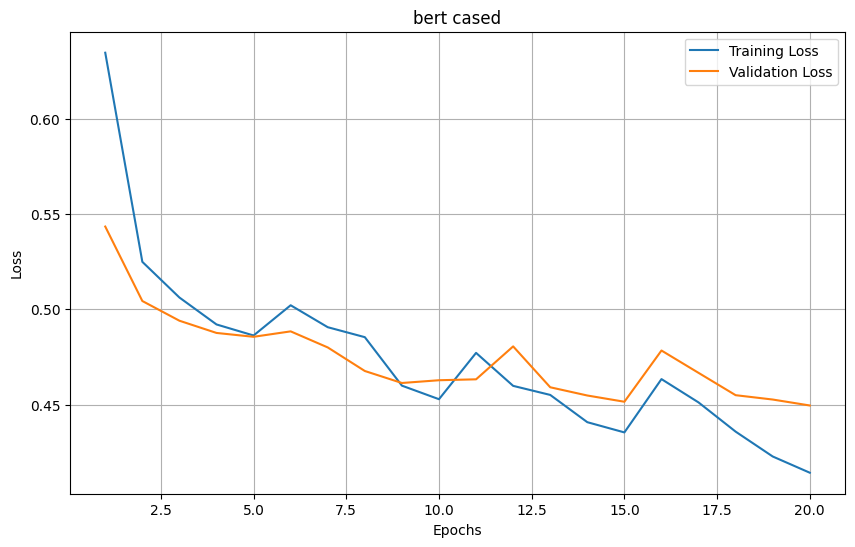

In [35]:
from accelerate import Accelerator
import time


train_path = "/content/CommonLitChallenge/data/dataset.zip"
train_data = pd.read_csv(train_path, compression='zip', sep=',')

config = {
    'model': 'bert-base-cased', # name of the model to be downloaded with huggingsface transformers
    'name': 'bert cased', # name of the model to be displayed on the results
    'max_length': 512,
    'batch_size': 4,  # si può provare ad aumentare ma occhio agli out of memory error
    'epochs': 20,
    'lr': 3e-4,
    'gradient_accumulation_steps': 16,
    'adam_eps': 1e-6,  # 1e-8 default
    'freeze_encoder': True,
    'fflayers': 1,
    'ffdropout': 0.2,
    'activation_function': 'relu'
}

features = ["length_ratio", "normalized_text_length", "karp_tfidf_scores",
            "normalized_text_misspelled_counter", "normalized_corrected_misspelled_counter", "normalized_2grams-cooccurrence-count",
            "normalized_2grams-correct-count", "normalized_3grams-correct-count", "normalized_4grams-correct-count",
            "normalized_3grams-cooccurrence-count", "normalized_4grams-cooccurrence-count",
            "semantic_similarity"]
feature_dim = len(features)
multioutput = True

input_cols = ["fixed_summary_text"]
target_cols = ["content","wording"]

train_loader, valid_loader, test_loader, tokenizer = pipeline(config, training_data=train_data, input_cols=input_cols, target_cols=target_cols,
                                                            features=features, split=0.2, oversample=True)
accelerator = Accelerator(gradient_accumulation_steps=config['gradient_accumulation_steps'])

model = RegressorModel(name=config["model"], fflayers=config["fflayers"],
                       ffdropout=config["ffdropout"],activation_function=config["activation_function"],
                       features_dim=feature_dim, target_cols=target_cols).to(device=accelerator.device)

trainer = Trainer(model=model, loaders=(train_loader, valid_loader), accelerator=accelerator, epochs=config["epochs"], lr=config["lr"])

start_time = time.time()
train_losses, val_losses = trainer.fit(multioutput)
elapsed_time = time.time() - start_time

plot_and_save_graph(config["epochs"], config["name"], train_losses["loss"], val_losses["loss"])

In [36]:
training_info = {
        'model-name': config["name"],
        'train-loss': train_losses["loss"][-1],
        'valid-loss': val_losses["loss"][-1],
        'train-content-loss': train_losses["content"][-1].item(),
        'valid-content-loss': val_losses["content"][-1].item(),
        'train-wording-loss': train_losses["wording"][-1].item(),
        'valid-wording-loss': val_losses["wording"][-1].item(),
        'elapsed-time': elapsed_time,
    }

print(training_info)

{'model-name': 'bert cased', 'train-loss': 0.41421016331142607, 'valid-loss': 0.44948765230511123, 'train-content-loss': 0.36280277371406555, 'valid-content-loss': 0.38946154713630676, 'train-wording-loss': 0.46561792492866516, 'valid-wording-loss': 0.5095139145851135, 'elapsed-time': 969.5983066558838}


In [37]:
trainer.evaluate(test_loader, device=accelerator.device)

AttributeError: ignored

# Retrain the model with the whole dataset and save it

In [ ]:
# TODO